In [170]:
# Import package
import h5py
import numpy as np
import sigpy.plot as pl
import sigpy as sp
%matplotlib inline

In [3]:
import cfl

In [4]:
import matplotlib.pyplot as plt

In [5]:
#read dataset: brain dataset
h5_dataset_brain = h5py.File('rawdata_brain_radial_96proj_12ch.h5', 'r')

In [6]:
h5_dataset_rawdata_name = list(h5_dataset_brain.keys())[0]
h5_dataset_trajectory_name = list(h5_dataset_brain.keys())[1]

trajectory = h5_dataset_brain.get(h5_dataset_trajectory_name).value
rawdata = h5_dataset_brain.get(h5_dataset_rawdata_name).value

In [88]:
gpu_number = 1

In [92]:
coor = trajectory[:2,:,:].transpose((1,2,0))
coor = sp.backend.to_device(coor,gpu_number)
rawdata_brain = rawdata[0,:,:,:].transpose((2,0,1))
rawdata_brain = sp.backend.to_device(rawdata_brain,gpu_number)
image = cfl.readcfl("img_igrid_brain")
image_sos = sp.util.rss(image,3)
sens_maps = image[:,:,0,:]/image_sos
sens_maps_t = sens_maps.transpose((2,0,1))
sens_maps_t = sp.backend.to_device(sens_maps_t,gpu_number)

In [93]:
S = sp.linop.Multiply((1,300,300),sens_maps_t)
NUFFT = sp.linop.NUFFT((12,300,300),coor)
Operator = NUFFT*S

In [228]:
W = sp.linop.Wavelet(img_rec.shape,axes = [-1,-2])
lamda = 0.000001
proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)

In [157]:
img_rec_now = sp.app.LinearLeastSquares(Operator,rawdata_brain,max_iter=100).run()

LinearLeastSquares: 100%|██████████| 100/100 [00:03<00:00, 32.15it/s, resid=5.11E-06]


In [180]:
img_rec = sp.app.LinearLeastSquares(Operator,rawdata_brain,proxg=proxg,max_iter=100).run()

LinearLeastSquares: 100%|██████████| 100/100 [00:08<00:00, 12.04it/s, resid=4.32E-04]


In [182]:
img_rec = sp.backend.to_device(img_rec)

In [163]:
img_rec.shape

(1, 300, 300)

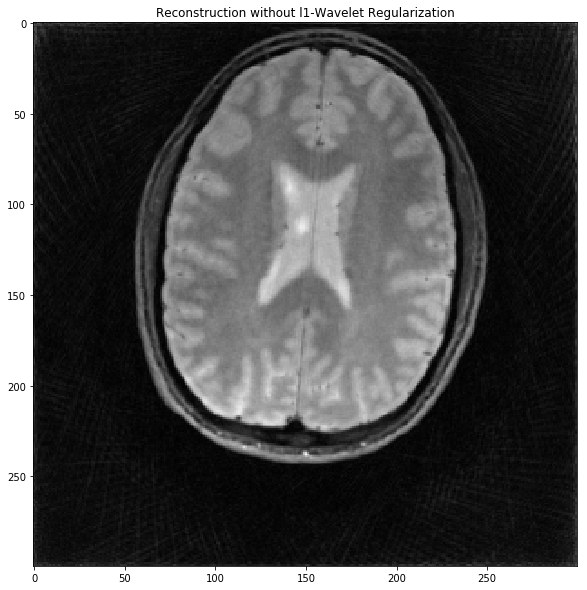

In [177]:
img_rec_now = sp.backend.to_device(img_rec_now)
im_abs_recon_now = abs(img_rec_now[0,:,:])
plt.figure(figsize=(20,10))
plt.title("Reconstruction without l1-Wavelet Regularization")
plt.imshow(im_abs_recon_now[::-1,:],cmap='gray')
plt.show()

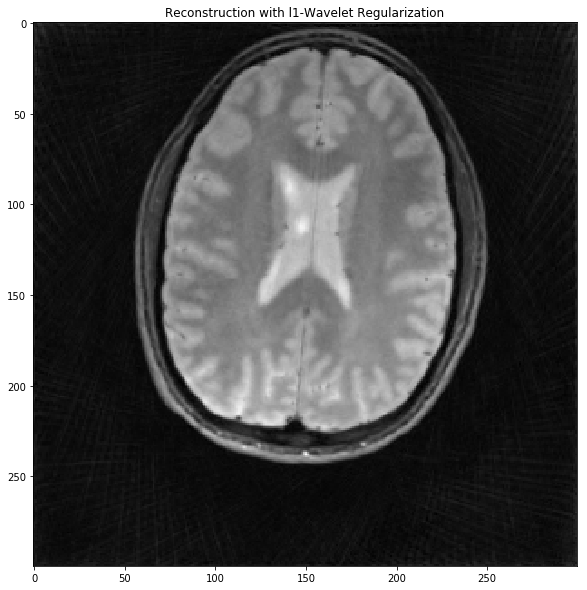

In [219]:
im_abs_recon = abs(img_rec[0,:,:])
plt.figure(figsize=(20,10))
plt.title("Reconstruction with l1-Wavelet Regularization")
plt.imshow(im_abs_recon[::-1,:],cmap='gray')
# plt.show()

In [203]:
rawdata_brain_2.shape

(12, 512, 96)

In [223]:
coor_subsample_2.shape

(512, 24, 2)

LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 35.15it/s, resid=3.41E-04]


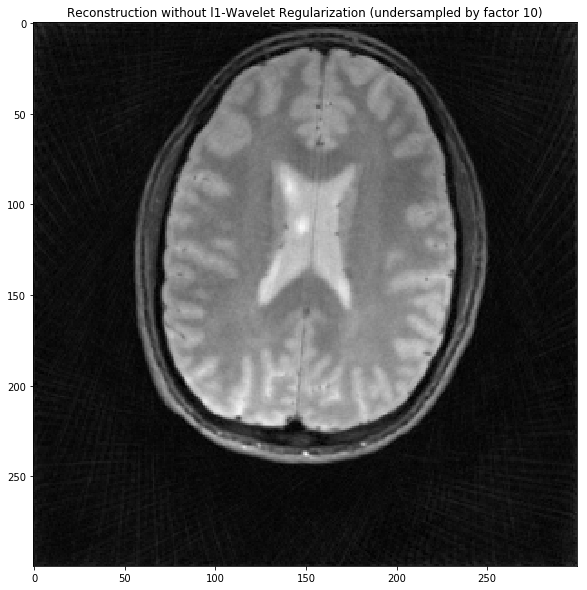

In [243]:
# Subsample of the radial data
#L_2 Normalization
lamda_l2 = 0.1
proxg_l2 = sp.prox.L2Reg((1,300,300),lamda_l2)
coor_subsample_2 = coor[:,::1,:]
rawdata_brain_2 = rawdata_brain[:,:,::1]
# pl.ScatterPlot(coor_subsample_2)
S_2 = sp.linop.Multiply((1,300,300),sens_maps_t)
NUFFT_2 = sp.linop.NUFFT((12,300,300),coor_subsample_2)
Operator_2 = NUFFT_2*S_2
img_rec_now_2 = sp.app.LinearLeastSquares(Operator_2,rawdata_brain_2,proxg=proxg_l2,max_iter=100).run()
img_rec_now_2 = sp.backend.to_device(img_rec_now_2)
im_abs_recon_now_2 = abs(img_rec_now_2[0,:,:])
plt.figure(figsize=(20,10))
plt.title("Reconstruction without l1-Wavelet Regularization (undersampled by factor %d)"%10)
plt.imshow(im_abs_recon_now_2[::-1,:],cmap='gray')
plt.show()